* Author: HN
* Project: ISI Pump and Dump Cryptocurremcy
* Date: October 2020
* Phase: Prelim
* Desc: This module focuses exclusively on the social signals, which is the comprehensive list we downloaded from __CRYPTOCOMPARE__.

__NOTE__ : This analysis introduces another perspective of analysis from just the social media stats. We ran similar random forest models to hopefully reveal any significant contribution to the prediction of pumps. Must make sure to keep track of the categories to tease out interaction later.

In [1]:
import os, sys
import pandas as pd 
import numpy as np
import requests 
from datetime import datetime, date, time, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mpl_finance import candlestick_ohlc
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.ticker as mticker
%load_ext autoreload
%matplotlib inline

In [2]:
p = pd.read_pickle('pump_data_with_y.pkl')
p.head(3)

,channelLink,channelTitle,currency,duration,exchange,priceBeforePump,signalTime,pumptime_edited,timestamp,pump_weekday,...,twitter_favourites_7,twitter_followers_7,twitter_following_7,twitter_lists_7,twitter_statuses_7,date_7,date_utc_7,pump_increase,pump_increase_percent,pump_increase_cat
0,https://t.me/crypto_pump_island,Crypto Pump Island,ADX,00:00,Binance,0.000011,2019-07-26T17:59:59Z,2019-07-26 17:59:59+00:00,1564163999,4,...,1473,5.406400e+12,2.540000e+10,797,691,2019-07-26 04:00:00,2019-07-26 11:00:00+00:00,80.0,7.0,1
1,https://t.me/SignalsKingdom,Signal Kingdom,ADX,00:53,Binance,0.000012,2019-07-05T17:00:32,2019-07-05 17:00:32+00:00,1562346032,4,...,1470,5.416800e+12,2.540000e+10,795,686,2019-07-05 03:00:00,2019-07-05 10:00:00+00:00,255.0,21.0,2
2,https://t.me/MaximumPump,Maximum Pump,ADX,00:02,Binance,0.000029,2019-04-25T19:15:21,2019-04-25 19:15:21+00:00,1556219721,3,...,1456,5.478200e+12,2.530000e+10,792,660,2019-04-25 05:00:00,2019-04-25 12:00:00+00:00,120.0,4.0,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## SOCIAL FEATURES

In [4]:
all_social  = ['analysis_page_views', 'charts_page_views', 'code_repo_closed_issues',
       'code_repo_closed_pull_issues', 'code_repo_forks',
       'code_repo_open_issues', 'code_repo_open_pull_issues',
       'code_repo_stars', 'code_repo_subscribers', 'comments', 'fb_likes',
       'fb_talking_about', 'followers', 'forum_page_views',
       'influence_page_views', 'markets_page_views', 'overview_page_views',
       'points', 'posts', 'reddit_active_users', 'reddit_comments_per_day',
       'reddit_comments_per_hour', 'reddit_posts_per_day',
       'reddit_posts_per_hour', 'reddit_subscribers', 'time',
       'total_page_views', 'trades_page_views', 'twitter_favourites',
       'twitter_followers', 'twitter_following', 'twitter_lists',
       'twitter_statuses', 'date', 'date_utc']

In [5]:
chart_features = ['analysis_page_views_0', 'charts_page_views_0',
                'markets_page_views_0', 'overview_page_views_0',
                'total_page_views_0', 'trades_page_views_0',
                'analysis_page_views_1', 'charts_page_views_1',
                'markets_page_views_1', 'overview_page_views_1',
                'total_page_views_1', 'trades_page_views_1',
                'analysis_page_views_2', 'charts_page_views_2',
                'markets_page_views_2', 'overview_page_views_2',
                'total_page_views_2', 'trades_page_views_2',
                'analysis_page_views_3', 'charts_page_views_3',
                'markets_page_views_3', 'overview_page_views_3',
                'total_page_views_3', 'trades_page_views_3',
                'analysis_page_views_4', 'charts_page_views_4',
                'markets_page_views_4', 'overview_page_views_4',
                'total_page_views_4', 'trades_page_views_4',
                'analysis_page_views_5', 'charts_page_views_5',
                'markets_page_views_5', 'overview_page_views_5',
                'total_page_views_5', 'trades_page_views_5',
                'analysis_page_views_6', 'charts_page_views_6',
                'markets_page_views_6', 'overview_page_views_6',
                'total_page_views_6', 'trades_page_views_6']

In [18]:
code_repo =  p.filter(regex='code_repo').columns.values.tolist()

In [19]:
reddit_features = p.filter(regex='reddit_').columns.values.tolist()

In [20]:
twitter_features = p.filter(regex='twitter_').columns.values.tolist()

In [21]:
facebook_features = p.filter(regex='fb_').columns.values.tolist()

In [22]:
p.filter(regex='points_').columns.values

array(['points_0', 'points_1', 'points_2', 'points_3', 'points_4',
       'points_5', 'points_6', 'points_7'], dtype=object)

In [23]:
post_features = ['posts_0', 'posts_1', 'posts_2', 'posts_3', 'posts_4', 'posts_5', 'posts_6', 'posts_7']

In [24]:
point_features  = ['points_0', 'points_1', 'points_2', 'points_3', 'points_4', 'points_5', 'points_6', 'points_7']

In [58]:
social_features = code_repo + chart_features + reddit_features + twitter_features + facebook_features + post_features + point_features

# Split Train and Set

In [59]:
X = p[social_features].values
y = p['pump_increase_cat'].values

In [60]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

### Scale Min-Max Scaler

In [61]:
mima = MinMaxScaler()

In [62]:
x_train_mima = mima.fit_transform(x_train)
x_test_mima = mima.transform(x_test)

## Random Forest Model

In [63]:
rfc = RandomForestClassifier(random_state=10)

In [64]:
param_grid = {'n_estimators': [200,500,750]
             ,'max_features': ['auto','sqrt','log2']
             ,'max_depth': [5,10,15]
             ,'criterion': ['gini','entropy']}

In [65]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10)
CV_rfc.fit(x_train_mima,y_train)

/Users/AdrianTran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500, 750], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 10, 15], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 500}

In [113]:
rfc = RandomForestClassifier(random_state=10)

In [67]:
rfc_best = RandomForestClassifier(criterion='gini',max_depth= 5, max_features='auto',n_estimators=500)

In [68]:
rfc_best.fit(x_train_mima,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
rfc_pred = rfc_best.predict(x_test_mima)

In [70]:
accuracy_score(y_test, rfc_pred)

0.4186046511627907

## Assessing Variable Importance

In [71]:
rf_features = pd.DataFrame(rfc_best.feature_importances_.reshape(1,-1), columns=social_features).T
rf_features['features'] = rf_features.index
rf_features = rf_features.reset_index(drop=True)
rf_features.columns = ['importance','features']


In [72]:
rf_features.sort_values('importance', inplace=True,ascending=False)
rf_features['rank'] = range(1,rf_features.shape[0]+1)
rf_features.to_pickle('rf_feature_importance.pkl')
rf_features.head()

,importance,features,rank
164,0.014617,twitter_lists_3,1
149,0.014213,twitter_lists_0,2
182,0.013629,twitter_followers_7,3
152,0.013120,twitter_followers_1,4
174,0.011890,twitter_lists_5,5


Text(0.5, 0, 'Random Forest Feature Importance')

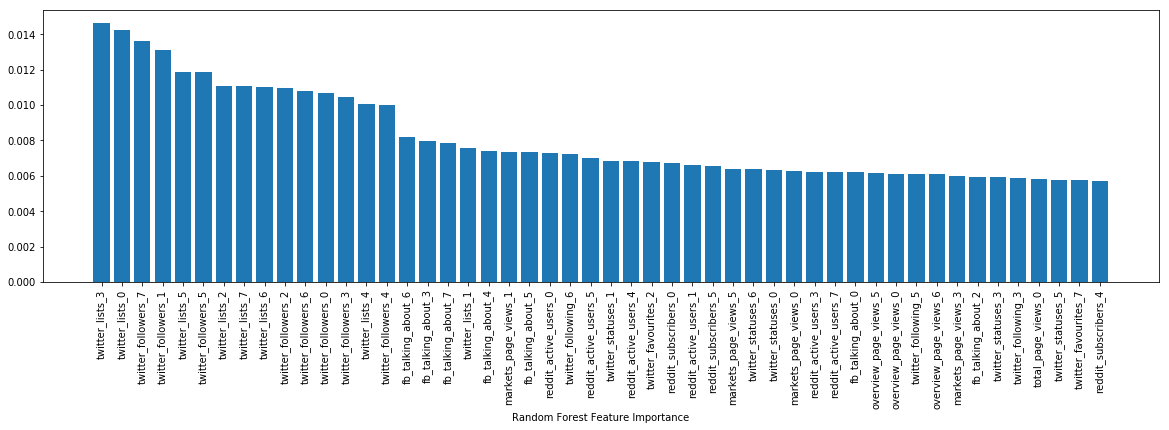

In [73]:
fig = plt.figure(figsize=(20,5))
plt.bar(height=rf_features.importance[:50], x=rf_features.features[:50])
plt.xticks(rf_features.features[:50],  rotation='vertical')
plt.xlabel('Random Forest Feature Importance')

## Cross-Validation

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [75]:
minmax_scaler = MinMaxScaler()
#Reuse the best parameters determined above
clf = RandomForestClassifier(criterion='entropy',max_depth= 10, max_features='auto',n_estimators=750)

In [76]:
k = 10
pipeline = Pipeline([('transformer',minmax_scaler),('estimator',clf)])
cv = KFold(n_splits=k)

In [77]:
cv_output = cross_val_score(pipeline,X,y,cv=cv)

In [78]:
print("Average Accuracy for Randrom Forest {}-Fold Validation {}".format(k,np.average(cv_output)))

Average Accuracy for Randrom Forest 10-Fold Validation 0.32696566998892573


# Multinomial Logistic Regressionm

In [79]:
lr = LogisticRegressionCV(multi_class='multinomial', random_state=10,solver="newton-cg",cv=5)

In [80]:
lr_best = LogisticRegressionCV(multi_class='multinomial', random_state=10,solver="newton-cg",cv=5)

In [81]:
lr_best.fit(x_train_mima, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=10, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [82]:
lr_best_pred = lr_best.predict(x_test_mima)

In [83]:
lr_best_pred

array([0, 0, 1, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 1, 2, 0, 0, 1,
       0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0,
       1, 3, 2, 0, 0, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 3])

In [84]:
accuracy_score(y_test, lr_best_pred)

0.27906976744186046

## Feature Importance

In [85]:
lr_coefs = np.average(lr_best.coef_, axis=0)
lr_coefs.shape

(218,)

In [86]:
lr_weights = pd.DataFrame(lr_coefs).T
lr_weights.columns =  social_features
lr_weights = lr_weights.T
lr_weights['features'] =  lr_weights.index
lr_weights = lr_weights.reset_index(drop=True)
lr_weights.columns = ['coef','features']
lr_weights['coef_abs'] = abs(lr_weights.coef)

In [87]:
lr_weights.sort_values('coef_abs',ascending=False,inplace=True)

Text(0.5, 0, 'Multinomial Logistic Regression Feature Importance')

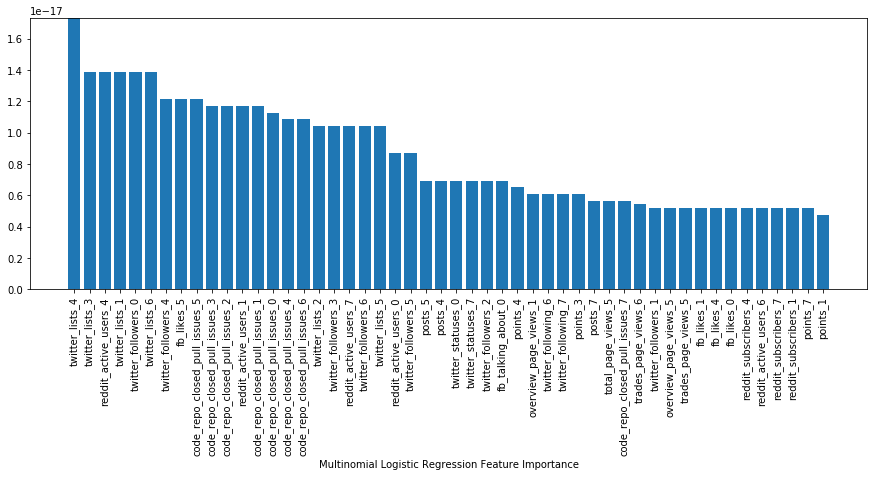

In [88]:
fig = plt.figure(figsize=(15,5))
plt.bar(height=lr_weights.coef_abs[:50], x=lr_weights.features[:50])
plt.xticks(lr_weights.features[:50],  rotation='vertical')
plt.xlabel('Multinomial Logistic Regression Feature Importance')